<a href="https://colab.research.google.com/github/hardiksharma2005/Reddit-Post-Classifier/blob/main/Reddit_Post_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
!pip install pandasql

In [63]:
import pandas as pd
import pandasql as ps

Loading the data

In [64]:
try:
    df = pd.read_csv("reddit data.csv")
    print("Data loaded")
    print(df.head())
except:
    print("csv file not found")

Data loaded
       id                                              title  score  \
0  ll1p9h  Wordcloud of trending video titles on YouTube ...      1   
1  ll1o4h  Wordcloud of trending videos on YouTube in the...      1   
2  ll15gx  Immunization in India. Source: https://niti.go...      1   
3  ll0iup  How to quickly estimate the impact of players ...      1   
4  ll0g9a  How to quickly estimate the impact of players ...      1   

                 author author_flair_text        removed_by  \
0             OmarZiada             OC: 1               NaN   
1             OmarZiada             OC: 1         moderator   
2  Professional_Napper_               NaN         moderator   
3              Viziball               NaN  automod_filtered   
4              Viziball               NaN         moderator   

   total_awards_received awarders  created_utc  \
0                    0.0       []   1613473961   
1                    0.0       []   1613473829   
2                    0.0       [

/tmp/ipython-input-2247407350.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("reddit data.csv")


Day 1: SQL Analysis using PandaSQL

In [65]:
if 'over_18' in df.columns:
    df['category'] = df['over_18'].apply(lambda x: 'NSFW' if x == True else 'Safe')
    print("created 'category' column for SQL analysis")
else:
    print("Column 'over_18' not found")
    df['category'] = 'Unknown'

created 'category' column for SQL analysis


In [66]:
#Insight: Do NSFW posts get higher scores than Safe posts?
print("\n Average Score by Category")
q1 = """
SELECT category, COUNT(*) as post_count, AVG(score) as avg_score
FROM df
GROUP BY category
ORDER BY avg_score DESC
"""
ps.sqldf(q1, locals())


 Average Score by Category


,category,post_count,avg_score
0,NSFW,1068,583.908240
1,Safe,189785,173.720779


In [67]:
# Insight: Classifying posts into 'Viral', 'Hot', or 'Normal' based on score
print("\n Viral post classification")
q2 = """
SELECT title, score,
       CASE
           WHEN score > 5000 THEN 'Viral'
           WHEN score > 1000 THEN 'Hot'
           ELSE 'Normal'
       END as virality_label
FROM df
LIMIT 5
"""
ps.sqldf(q2, locals())


 Viral post classification


,title,score,virality_label
0,Wordcloud of trending video titles on YouTube ...,1,Normal
1,Wordcloud of trending videos on YouTube in the...,1,Normal
2,Immunization in India. Source: https://niti.go...,1,Normal
3,How to quickly estimate the impact of players ...,1,Normal
4,How to quickly estimate the impact of players ...,1,Normal


In [68]:
# Insight: Find the #1 highest ranked post within each category (Safe vs NSFW)
print("\n Top post per category (Window Function)")
q3 = """
SELECT title, category, score,
       RANK() OVER (PARTITION BY category ORDER BY score DESC) as rank
FROM df
LIMIT 10
"""
ps.sqldf(q3, locals())


 Top post per category (Window Function)


,title,category,score,rank
0,"Pornhub traffic in Hawaii during the ""missile ...",NSFW,63569,1
1,Tinder over 3 years (18-21 Male) [OC],NSFW,59130,2
2,"""Fuuuuck"", orthographic repetition on Twitter ...",NSFW,38419,3
3,Six months on tinder as a young sex worker loo...,NSFW,34248,4
4,Reddit's favorite swear word is 'shit'; the su...,NSFW,31961,5
5,Pornhub’s year in review,NSFW,25833,6
6,[oc] How taboo and popular are sexual fetishes...,NSFW,25715,7
7,NSFW Heat Map of Reddit's Favorite Porn Cross-...,NSFW,24508,8
8,"On /r/gonewild, 18 year-olds rule [OC]",NSFW,18618,9
9,Playboy’s Cover Girls’ Hair Colors — statistic...,NSFW,17578,10


Data Analysis (EDA)

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set_style("whitegrid")

/tmp/ipython-input-1435078278.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['over_18'].astype(str), palette='coolwarm')


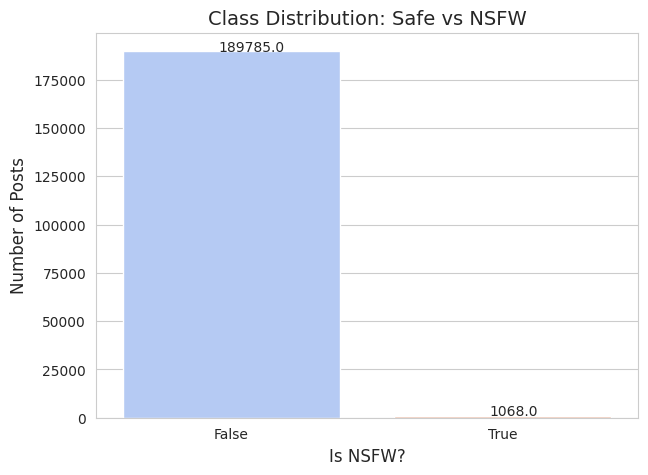

In [70]:
# 1. CLASS IMBALANCE CHECK
plt.figure(figsize=(7, 5))
ax = sns.countplot(x=df['over_18'].astype(str), palette='coolwarm')
plt.title('Class Distribution: Safe vs NSFW', fontsize=14)
plt.xlabel('Is NSFW?', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Add labels to bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 5))
plt.show()

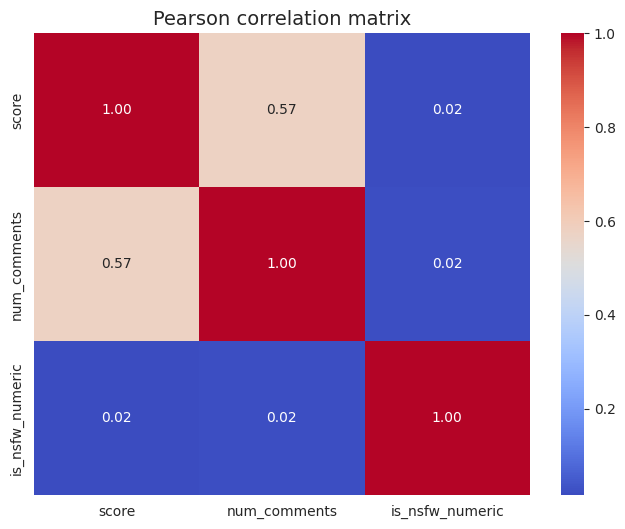

In [71]:
# 2. CORRELATION HEATMAP
# We check relationships between Score, Comments, and NSFW status.
plt.figure(figsize=(8, 6))
# Convert boolean 'over_18' to integer (0 or 1) for correlation
df['is_nsfw_numeric'] = df['over_18'].astype(int)
numeric_cols = df[['score', 'num_comments', 'is_nsfw_numeric']]

sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson correlation matrix', fontsize=14)
plt.show()

Text(0.5, 1.0, 'common words in SAFE posts')

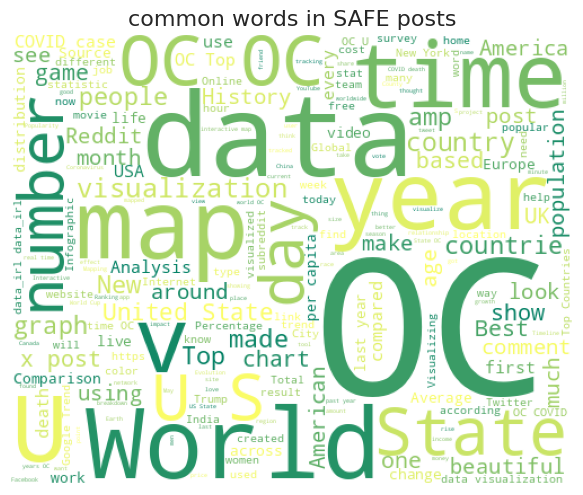

In [72]:
# 3. COMPARATIVE WORD CLOUDS
# We separate the text to see what words trigger the "NSFW" label.
safe_text = " ".join(df[df['over_18'] == False]['title'].astype(str))
nsfw_text = " ".join(df[df['over_18'] == True]['title'].astype(str))

plt.figure(figsize=(16, 8))

# Safe Word Cloud
plt.subplot(1, 2, 1)
wc_safe = WordCloud(width=500, height=400, background_color='white', colormap='summer').generate(safe_text)
plt.imshow(wc_safe)
plt.axis('off')
plt.title('common words in SAFE posts', fontsize=16)

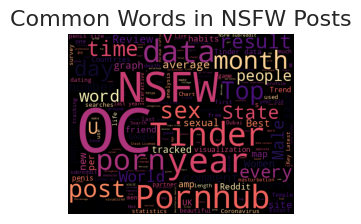

In [85]:
# NSFW Word Cloud
plt.subplot(1, 2, 2)
wc_nsfw = WordCloud(width=500, height=400, background_color='black', colormap='magma').generate(nsfw_text)
plt.imshow(wc_nsfw)
plt.axis('off')
plt.title('Common Words in NSFW Posts', fontsize=16)

plt.show()

NLP Preprocessing

In [86]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [88]:
if len(df) > 20000:
    print(f"({len(df)} rows) Downsampling")
    df_small = df.sample(n=20000, random_state=42).copy()
else:
    df_small = df.copy()

(190853 rows) Downsampling


In [89]:
# 2. TEXT CLEANING
df_small['clean_title'] = df_small['title'].astype(str)

In [90]:
# 3. SPARSE VECTORIZATION
print("Vectorizing text")
tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
X = tfidf.fit_transform(df_small['clean_title'])
y = df_small['over_18']

print(f"Matrix shape: {X.shape}")

Vectorizing text
Matrix shape: (20000, 3000)


Model Training

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

Day 4 Handling imbalance data and model training

In [92]:
# 1. SEPARATE THE CLASSES
df_safe = df[df['over_18'] == False]
df_nsfw = df[df['over_18'] == True]

print(f"Safe counts: {len(df_safe)}, NSFW counts: {len(df_nsfw)}")

Safe counts: 189785, NSFW counts: 1068


In [93]:
# 2. DOWNSAMPLE THE MAJORITY (SAFE)
df_safe_downsampled = resample(df_safe,
                               replace=False,    # sample without replacement
                               n_samples=len(df_nsfw), # match minority count
                               random_state=42)

In [94]:
# 3. COMBINE BACK TOGETHER
df_balanced = pd.concat([df_safe_downsampled, df_nsfw])

print(f"balanced dataset created {len(df_balanced)} rows total")
print(df_balanced['over_18'].value_counts())

balanced dataset created 2136 rows total
over_18
False    1068
True     1068
Name: count, dtype: int64


In [95]:
# 4. VECTORIZE THE BALANCED DATA
print("re vectorization of balanced data")
tfidf_balanced = TfidfVectorizer(max_features=3000, stop_words='english')
# Ensure text is string
df_balanced['clean_title'] = df_balanced['title'].astype(str)

X_bal = tfidf_balanced.fit_transform(df_balanced['clean_title'])
y_bal = df_balanced['over_18']

re vectorization of balanced data


In [99]:
# 5. SPLIT & TRAIN
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

print("Random Forest training")
rf_balanced = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42)
rf_balanced.fit(X_train_b, y_train_b)
y_pred_b = rf_balanced.predict(X_test_b)

print("Random Forest performance")
print(classification_report(y_test_b, y_pred_b))

Random Forest training
Random Forest performance
              precision    recall  f1-score   support

       False       0.70      0.94      0.81       216
        True       0.91      0.59      0.72       212

    accuracy                           0.77       428
   macro avg       0.81      0.77      0.76       428
weighted avg       0.81      0.77      0.76       428



In [97]:
# 6. Train Decision Tree
print("Training Decision Tree")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_b, y_train_b)
y_pred_dt = dt_model.predict(X_test_b)

print("Decision Tree performance")
print(classification_report(y_test_b, y_pred_dt))

Training Decision Tree
Decision Tree performance
              precision    recall  f1-score   support

       False       0.74      0.81      0.78       216
        True       0.79      0.71      0.75       212

    accuracy                           0.76       428
   macro avg       0.77      0.76      0.76       428
weighted avg       0.77      0.76      0.76       428

